# Numerical Methods Lab 4: More Data Analysis & Data Transformation 

[xkcd comic #26: Fourier](https://xkcd.com/26/)

![xkcd: Fourier](fourier.jpg)


## Filtering Data 
Data filtering is the process of reducing data to the most relevant information - essentially "clarifying" the signal. There are a number of ways to filter data, for instance:

* Sliding window / moving average 
* Gaussian moving average 

### Sliding window / moving average 
The sliding window works by creating a series of averages in "windows" of a dataset, where the window is essentially a fixed length over which the average is calculated. There are many ways to express it mathematically, one way is:

$$ y_n = \frac{1}{2k+1} \sum^{k}_{i=-k} x_{n + i} $$

Its purpose is to reduce the amplitude of noise while leaving the linear trend unchanged. There are a number of ways to implement this in Python, particularly depending on how you define boundary conditions for the average. 

Let's consider a simple example with no boundary conditions. We can define our noisy data as:

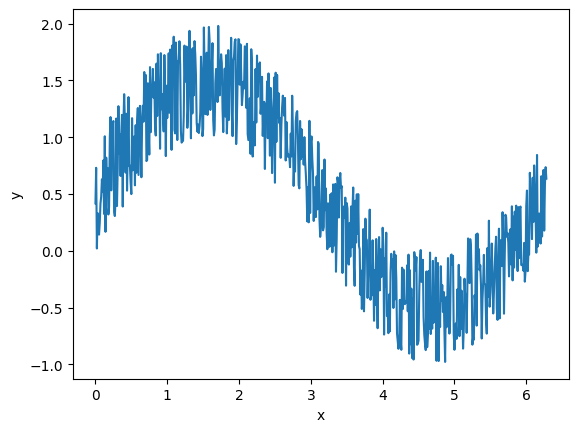

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

np.random.seed(1)

x = np.arange(0, 2 * np.pi, 0.01)
y = np.sin(x) + np.random.uniform(size=len(x)) 

fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

Now, we can define a moving average for the data:

In [2]:
def moving_average(da, k):
    result = np.zeros(len(da))

    for i in range(k+1, len(da) - (k+1)):
        for j in range(-k, k+1):
            result[i] += da[i+j]

        result[i] = result[i] / (2*k + 1)

    return result   

Finally, we can plot the result of the moving average, with a window size of 41. Mathematically, it would look like this:

$$ y_n = \frac{1}{41} \sum^{20}_{i=-20} x_{n + i} $$

When plotting the moving average, we have trimmed the data so we don't see any zeros:

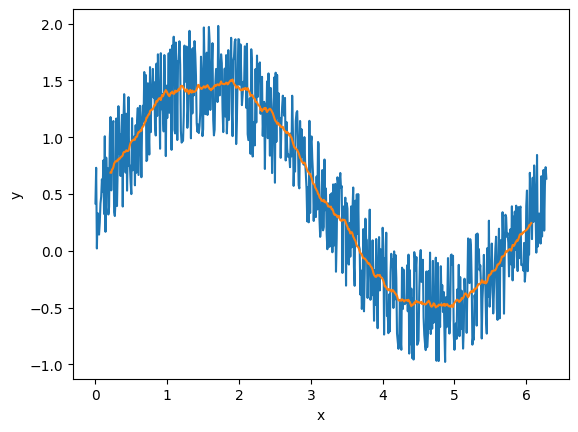

In [5]:
fig, ax = plt.subplots()
ax.plot(x, y)
ax.plot(x[21:-21], moving_average(y, 20)[21:-21])   # strip off the zeros 
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()  

Of course, scipy provides some functions to calculate the sliding window average. In the assignments, I prefer for you to create your own implementation of the function. 

To compute the sliding window average using scipy, we can use *uniform_filter1d* from scipy.ndimage:

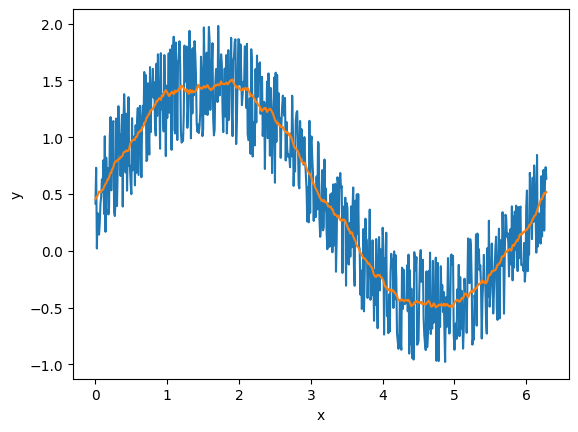

In [6]:
from scipy.ndimage import uniform_filter1d

fig, ax = plt.subplots()
ax.plot(x, y)
ax.plot(x, uniform_filter1d(y, 41, mode='nearest'))
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()  

### Gaussian moving average 
Another way to reduce noise in a dataset is to use the Gaussian moving average filter. It works exactly the same as the sliding window, except instead of using equal weights for each value in the calculation, it uses a Gaussian distribution to assign the weights. We can express it mathematically as 

$$ y_n = \sum_{i=1}^k w_i(n)x_i$$ 

where 

$$ w_i(n) = \frac{\frac{1}{\sqrt{2\pi}}\exp\left[ \frac{-(n-i)^2}{2k^2} \right]}{\sum_{i=1}^k\frac{1}{\sqrt{2\pi}}\exp\left[ \frac{-(n-i)^2}{2k^2} \right]}$$

One advantage of using the Gaussian weights in this moving average is that it is able to reduce noice far better than when using the sliding window average. One example implementation in Python is like this:

In [7]:
def gaussian_moving_average(da, k):
    result = np.zeros(len(da))

    for i in range(len(da)):
        weights = (1 / (2 * np.pi)) * np.exp(-(np.arange(len(da)) - i)**2 / (2 * k**2))
        weights = weights / sum(weights)
        result[i] = sum(da * weights)

    return result

We can test this on our mock data:

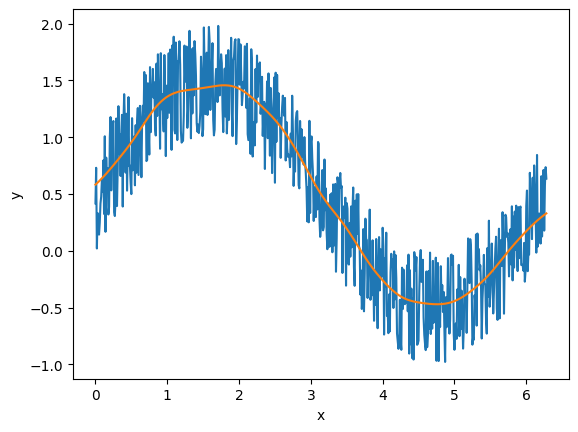

In [13]:
fig, ax = plt.subplots()
ax.plot(x, y)
ax.plot(x, gaussian_moving_average(y, 20))
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()  

You can clearly see that the Gaussian moving average reduces the noise in the data far more effectively than the sliding window average, and with a smaller window size!

Of course, we do not need to manually implement this every time we would like to use the filter. We can use *gaussian_filter1d* from scipy.ndimage:

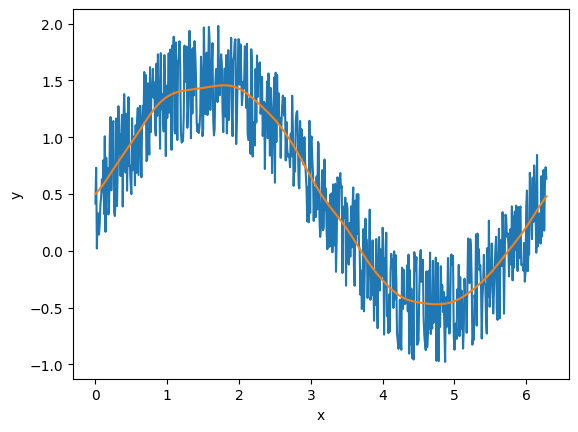

In [12]:
from scipy.ndimage import gaussian_filter1d 

fig, ax = plt.subplots()
ax.plot(x, y)
ax.plot(x, gaussian_filter1d(y, 20, mode='nearest'))
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()  

## Measurements of correlation 

Correlation implies an interdependence of quantities, meaning that there is a statistical relationship between two variables, or two datasets. 

As an example, we can generate two time series, $a$ and $b$, which are created using values of each other:

In [14]:
a = np.zeros(50000)
b = np.zeros(50000)

for i in range(1, 50000) :
    a[i] = a[i - 1] + 0.01 * b[i - 1]
    b[i] = b[i - 1] - 0.05 * a[i - 1] - 0.01 * b[i - 1] + 0.001*np.random.randn() # add a little noise so that the arrays aren't just zero

Let's have a look at this data together:

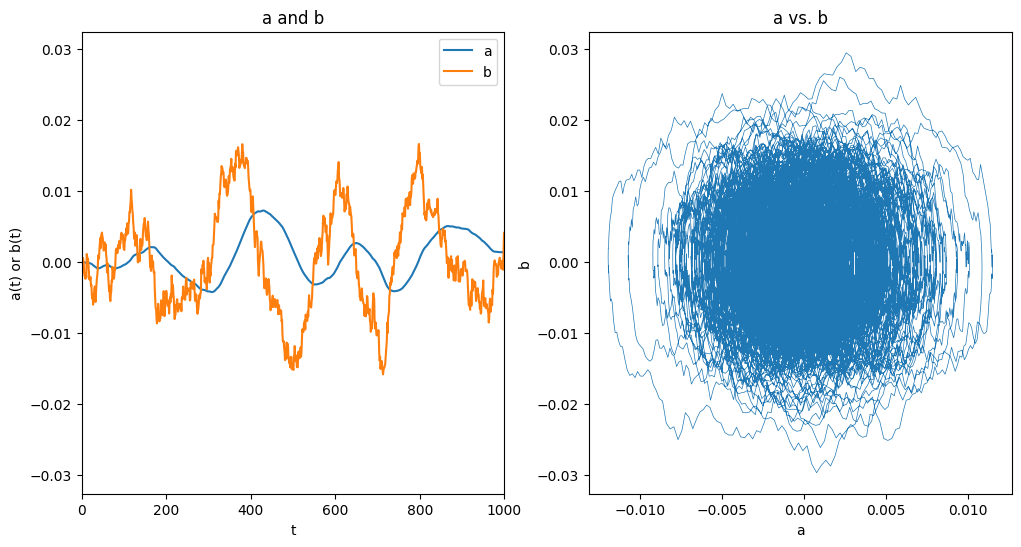

In [17]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax.plot(a, label="a")
ax.plot(b, label="b")

ax.set_xlabel("t")
ax.set_ylabel("a(t) or b(t)")
ax.set_title("a and b")

ax.set(xlim=[0, 1000])

ax.legend()

ax2.plot(a, b, linewidth=0.5)
ax2.set_xlabel("a")
ax2.set_ylabel("b")
ax2.set_title("a vs. b")

plt.show()

### Autocorrelation

Recall from the last lecture we were introduced to the Pearson correlation coefficient, that was essentially a measure of the strength of a linear relationship between two variables. It is defined as 

$$ \rho_{x,y} = \frac{\text{cov}(x, y)}{\sqrt{\text{var}(x) \text{var}(y)}} $$ 

One useful application of the Pearson correlation coefficient is within the *autocorrelation function*. The autocorrelation function measures the correlation between data in a time series $x_t$ with itself at a later time $x_{t + n}$ - this means that it is the Peason correlation between these values at later times.  There is a range of applications for the autocorrelation function in real data, for instance, you can use it to find a periodic signal that is hidden by noise. 

The autocorrelation function returns results on a scale from $-1$ to $1$. There are many trends that can exist in an autocorrelation plot, for instance:

* **Positive autocorrelation**: when the autocorrelation values are positive, this suggests that there is a positive relationship between the past data points and the current data at a given lag. Depending on the amount of lag considered, this could indicate an upward trend in the data points, or even seasonality. 

* **Negative autocorrelation**: when the autocorrelation values are negative, this suggests that there is a negative relationship between the past data points and the current data at a given lag. Once again, depending on the amount of lag considered, this could indicate a downward trend in the data points, or seasonality. 

* **Autocorrelation around (or close to) zero**: this suggests that there is little to no relationship between the past data points and the current data. 

* **A peak in the autocorrelation**: at higher lags, there may be peaks in the autocorrelation - this suggests that there is a stronger relationship between the past data and the current data, and may represent a more-pronounced seasonality at that interval. 

* **Multiple peaks in the autocorrelation**: with a sufficient amount of lags considered, you may observe multiple peaks in the autocorrelation. This is a strong indication of seasonality in the data, and understanding the seasonal patterns present enables you to make predictions.

In [18]:
def pearson_correl(x,y):
    return np.mean((x - np.mean(x)) * (y - np.mean(y))) / np.sqrt(np.var(x) * np.var(y))

def autocorr(x,n):
    """ 
    Parameters

    x:  the series data to be tested for autocorrelation 

    n:  a series of numbers (lags) on which the autocorrelation function will be tested
    """
    N = len(x)
    T = len(n)
    c = np.zeros(T)

    for i in range(T):
        c[i] = pearson_correl(x[0:N - n[i]] , x[n[i]:]) 

    return c

Let's now compute the autocorrelation function of our data, $a$ and $b$. Let's see how the first 1000 time steps are correlated to one another:

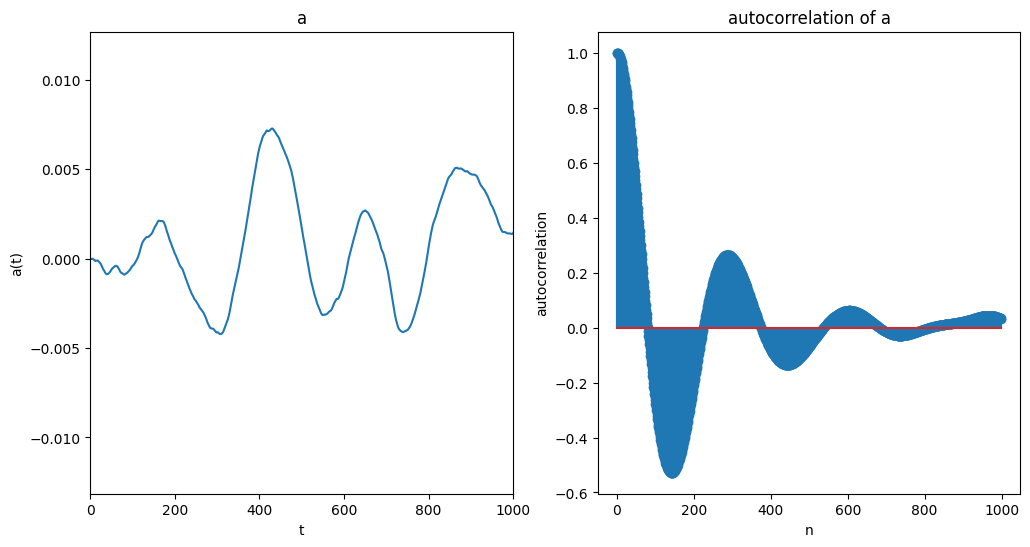

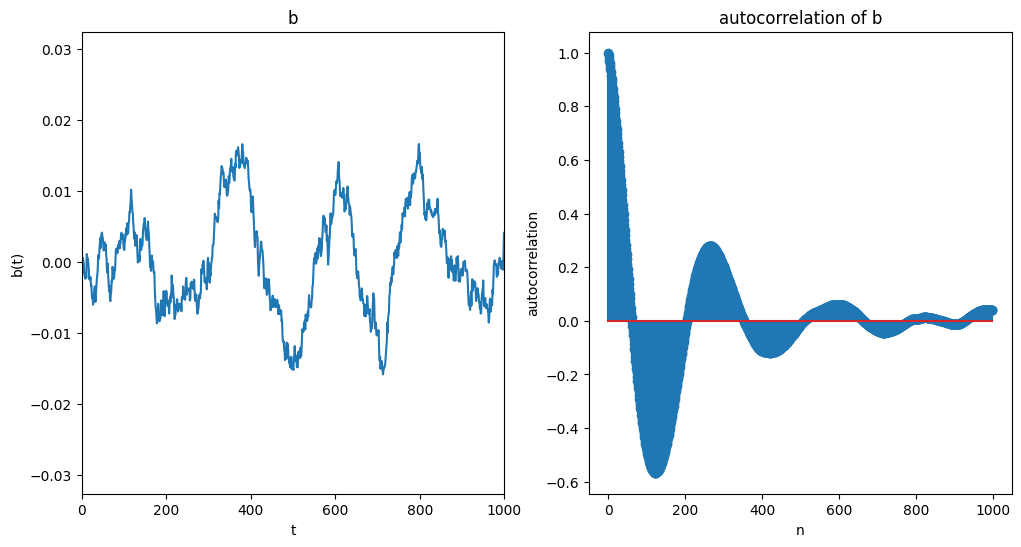

In [24]:
n = np.arange(0,1000) 

c = autocorr(a, n)
c2 = autocorr(b, n)

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax.plot(a)
ax2.stem(c)

ax.set(xlim=[0, 1000])
# ax2.set(xlim=[0, 10])

ax.set_xlabel("t")
ax.set_ylabel("a(t)")
ax2.set_xlabel("n")
ax2.set_ylabel("autocorrelation")
ax.set_title("a")
ax2.set_title("autocorrelation of a")
plt.show()

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax.plot(b)
ax2.stem(c2)

ax.set(xlim=[0, 1000])

ax.set_xlabel("t")
ax.set_ylabel("b(t)")
ax2.set_xlabel("n")
ax2.set_ylabel("autocorrelation")
ax.set_title("b")
ax2.set_title("autocorrelation of b")
plt.show()

The bars in this plot shows how much the past data impacts the following data. 

In an autocorrelation plot, the first value is always equal to $1$ - this is because the first data point can always explain the value of the first data point. 

What is really interesting in this plot is that we have a sort of sinusoidal pattern in the autocorrelation - this implies that there is some *seasonality* in the data! Further analysis can tell us more about the seasonality that we observe here. 

One way to do this is to compute the differences between the peaks of the autocorrelation function. Since the maximum is ways the first data point, one way to do this is to consider the difference between the peaks in the autocorrelation. A super neat way to do so (without calculus) is like this:

In [22]:
inflection = np.diff(np.sign(np.diff(c))) # Find the second-order differences
peaks = (inflection < 0).nonzero()[0] + 1 # Find where they are negative
print(peaks)

[288 604 966]


This provides us the indices of the various peaks present in the autocorrelation function. Then, we can find the delay by working out which of these indices results in the maximum value in the autocorrelation function:

In [23]:
delay = peaks[c[peaks].argmax()]
print(delay)

288


### Cross-correlation

Cross-correlation is a measure of the correlation of a time series $x_t$ with another time series $y_{t+n}$ at a later time. It's useful to find the offset between two time series, and can be interpreted as:

* **Positive cross-correlation**: positive values at a given lag indicates that the $x$ time series leads ahead of the $y$ time series
* **Negative cross-correlation**: negative values at a given lag indicates that the $y$ time series leads ahead of the $x$ time series

In [25]:
def crosscorr(x,y,n):
    N = len(x)
    T = len(n)
    c = np.zeros(T)

    for i in range(T):
        c[i] = pearson_correl(x[0:N - n[i]], y[n[i]:])
        
    return c

Let's compute the cross-correlation of our $a$ and $b$ time series for the first 1000 timesteps:

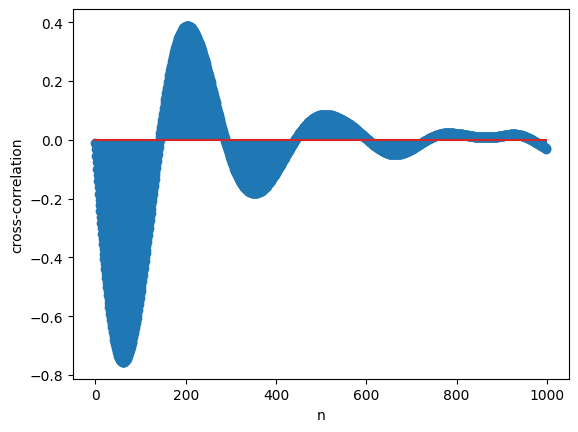

In [26]:
c_ab = crosscorr(a, b, n)

fig, ax = plt.subplots()
ax.stem(c_ab)
ax.set_xlabel("n")
ax.set_ylabel("cross-correlation")
plt.show()

## Fourier transformations

The idea behind the Fourier method is that any complicated function can be expressed as a sum of sine and cosine waves.

Waves contain many characteristics, for instance:

* Its *amplitude*, $A$, is a measure of the distance between the peak value and a baseline value

* Its *wavelength*, $\lambda$, measures the distance between successive peaks or troughs

* Its *period*, $T$, measures the amount of time for a wave to make a complete cycle (e.g., from peak to peak, or trough to trough)  

* Its *frequency*, $f$ measures how many waves pass through a fixed point in a given time frame. Typically, it can be measured as the number of cycles that pass within a time of 1 second, and has units of Hertz. The relationship between the period and frequency is 

$$ T = \frac{1}{f} $$

* Its *angular frequency*, $\omega$, is a measure of the frequency but in radians per second. It is essentially a rotation rate, and is related to the frequency and period as 

$$ \omega = 2\pi f = \frac{2\pi}{T}$$

* Its *phase*, $\phi$, is an angle-like quantity that is a measure of the fraction of a cycle at a point in time. It can also be used as a measure of the offset between two waves in space or time. 

When measuring waves, we need to specify how often we sample the wave in time - this is known as *sampling*. Hence, the rate at which we sample the wave is the *sampling rate*. If we sample a wave at a rate of 20Hz, then that means that we are sampling 20 points in 1 second. 

The Fourier transform tells us the extent to which different frequencies are present in an original function or time series. Consider a function $f(x)$, then the Fourier transform is defined as 

$$ \hat{f}(k) = \int_{-\infty}^\infty f(x) \exp\left[ -i2\pi k x\right] \: dx$$

and its inverse is 

$$ f(x) = \int_{-\infty}^\infty \hat{f}(k) \exp\left[ i2\pi k x\right] \: dk $$

Recalling that Euler's formula

$$ \exp[ix] = \cos(x) + i\sin(x) $$

is a way to link trigonometric functions to the complex domain.

Note that these expressions represent the *continuous* Fourier transform, and this works when you have a continuous transformation of a continuous signal. 

In reality, we typically have a sample of a signal, i.e. the signal is *discrete*. This means that practically we use the discrete Fourier transform instead. The discrete Fourier transform transforms a sequence of evenly spaced signal to the information about the frequency of all the sine waves needed to sum up to the original time domain signal. This is defined as 

$$ X_k = \sum_{x=0}^{N-1} x_n \exp \left[ \frac{-i 2\pi k n}{N}\right] = \sum_{x=0}^{N-1} x_n \left[ \cos\left(\frac{2\pi kn}{N}\right) - i\sin\left(\frac{2\pi kn}{N}\right) \right]$$

where $N$ is the number of samples, $n$ is the current sample, $k$ is the current frequency where $k \in [0, N-1]$, $x_n$ is the value of sine at a sample $n$, and $X_k$ is the discrete fourier transform containing information about the amplitude and phase. 

Let's consider a manual implementation of the discrete Fourier transform in Python:

In [27]:
def dft(x):
    N = len(x) 
    n = np.arange(N)
    k = n.reshape((N, 1))
    
    e = np.exp((-2j * np.pi * k * n) / N)

    return np.dot(e, x)

A few remarks on the implementation here: 

* The *reshape* function is a better way of converting a row vector into a column vector. It keeps the data points, but rearranges them into either a column vector, or a matrix as desired 

* Imaginary numbers in Python are represented by $j$ instead of $i$

Let's first consider a very simple example of a function made up of three sine waves of frequencies 1, 3 and 5, and amplitudes 3, 0.5 and 1. We will add up the sine waves with a sampling rate of 100Hz:

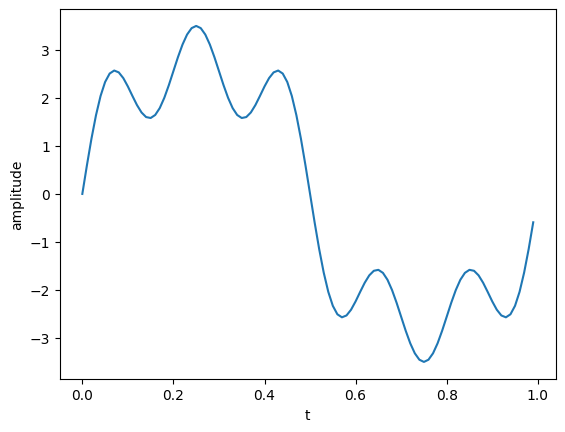

In [28]:
sampling_rate = 100 
sampling_interval = 1 / sampling_rate 

t = np.arange(0, 1, sampling_interval)

# first sine wave
x = 3 * np.sin(2 * np.pi * 1 * t)

# second sine wave 
x += 0.5 * np.sin(2 * np.pi * 3 * t)

# third sine wave 
x += np.sin(2 * np.pi * 5 * t)

fig, ax = plt.subplots()
ax.plot(t, x)
ax.set_xlabel("t")
ax.set_ylabel("amplitude")
plt.show()

Now, let's perform the discrete Fourier transform on this function obtain the frequencies of the sine waves:

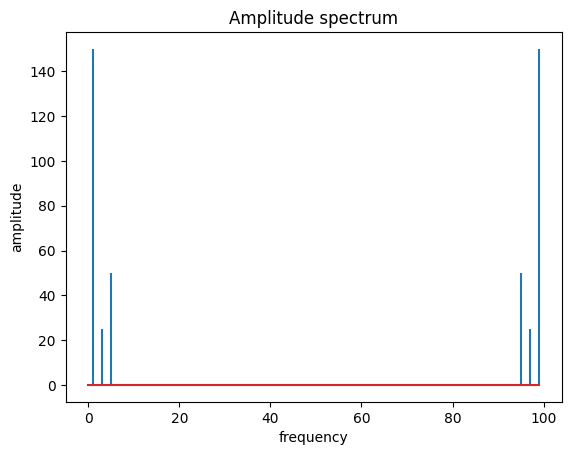

In [29]:
dft_x = dft(x)

# obtain the frequencies searched
N = len(dft_x)
n = np.arange(N)
T = N / sampling_rate 
freq = n / T 

fig, ax = plt.subplots()
ax.stem(freq, abs(dft_x), markerfmt=" ")   # take the real part of the DFT
ax.set_xlabel("frequency")
ax.set_ylabel("amplitude")
ax.set_title("Amplitude spectrum")
plt.show()

Notice how the output of the discrete Fourier transform is symmetric at a frequency of $\sim 50$ - i.e. at half the sampling rate. This frequency is known as the *Nyquist frequency*, and is a result of the Nyquist-Shannon theorem stating that "a signal sampled at a rate can be fully reconstructed provided it only contains frequency components that are below half of the sampling frequency". This means that the highest frequency that can be output by a discrete Fourier transform is the Nyquist frequency. 

Since the output is symmetric, that means that we can simplify the plot to contain only one side of the transform result. 

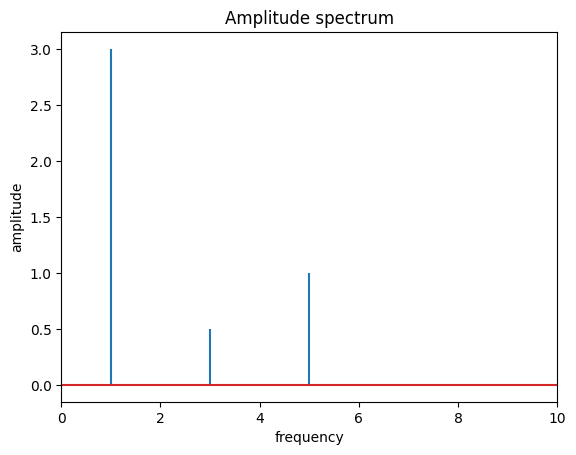

In [31]:
f_nyquist = int(sampling_rate / 2)

freq_oneside = freq[:f_nyquist]
dft_x_oneside = dft_x[:f_nyquist]

# normalise the amplitude by the Nyquist frequency 
dft_x_oneside = dft_x_oneside / f_nyquist

fig, ax = plt.subplots()
ax.stem(freq_oneside, abs(dft_x_oneside), markerfmt=" ")
ax.set_xlabel("frequency")
ax.set_ylabel("amplitude")
ax.set_title("Amplitude spectrum")
ax.set(xlim=[0,10])
plt.show()

We have successfully resolved the frequencies and the amplitudes of the sine waves that were used to make up our function!

In reality, computing the discrete Fourier transform can be quite time-intensive, particularly if we use a large sampling rate. This is where the *Fast Fourier Transform* comes in! The Fast Fourier Transform is an algorithm that exploits some symmetries in the discrete Fourier transform in order to reduce complexity. 

Let's consider the equation for the discrete Fourier transform again:

$$ X_k = \sum_{x=0}^{N-1} x_n \exp \left[ \frac{-i 2\pi k n}{N}\right]$$

and let's compute the $(k+N)^\text{th}$ term

$$ \begin{split}
X_{k + N} & = \sum_{x=0}^{N-1} x_n \exp \left[ \frac{-i 2\pi (k + N) n}{N}\right] \\ 
& = \sum_{x=0}^{N-1} x_n \exp \left[ \frac{-i 2\pi N n}{N}\right] \cdot \exp \left[ \frac{-i 2\pi k n}{N}\right] \\
&= \sum_{x=0}^{N-1} x_n \exp \left[ -i 2\pi n\right] \cdot \exp \left[ \frac{-i 2\pi k n}{N}\right]
\end{split}$$

However, $\exp \left[ -i 2\pi n\right] = 1$, so

$$ X_{k + N} = \sum_{x=0}^{N-1} x_n \exp \left[ \frac{-i 2\pi k n}{N}\right] $$

This implies that $X_{k + i\cdot N} = X_k$ for any integer $i$.

We don't actually need to manually implement the Fast Fourier Transform in Python, as it is provided by numpy. We can use it like this:

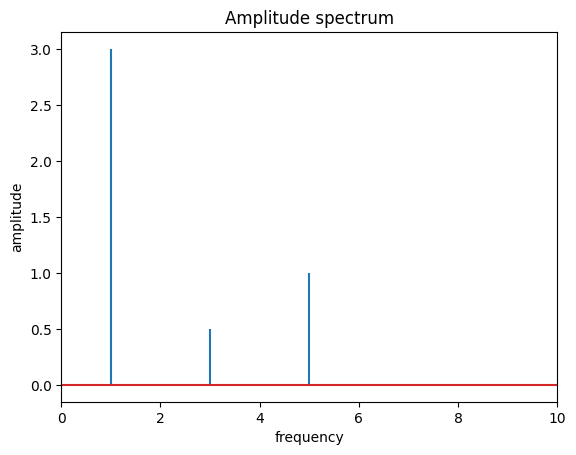

In [32]:
from numpy.fft import fft

fft_x = fft(x)
fft_x_oneside = fft_x[:f_nyquist] / f_nyquist

fig, ax = plt.subplots()
ax.stem(freq_oneside, abs(fft_x_oneside), markerfmt=" ")
ax.set_xlabel("frequency")
ax.set_ylabel("amplitude")
ax.set_title("Amplitude spectrum")
ax.set(xlim=[0, 10])
plt.show()

Numpy also calculates the sampling frequencies for you for a given window length $n$ and sampling interval $d$:

In [33]:
from numpy.fft import fftfreq

print(fftfreq(x.size, d=sampling_interval))
print(freq)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49. -50. -49. -48. -47. -46. -45.
 -44. -43. -42. -41. -40. -39. -38. -37. -36. -35. -34. -33. -32. -31.
 -30. -29. -28. -27. -26. -25. -24. -23. -22. -21. -20. -19. -18. -17.
 -16. -15. -14. -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.
  -2.  -1.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89.
 90. 91. 92. 93. 94. 95. 96. 97. 98. 99.]


The output frequencies from *fftfreq* are in a slightly different format: after the Nyquist frequency, the frequencies are mirror reflected instead.